## [ibovespa-stocks 브라질 주식 데이터 분석] - Prophet 활용
 * [경제-주식]
 * 브라질 증권 거래소의 주식 - Stocks from the Brazilian stock exchange
 * 데이터 출처 : https://www.kaggle.com/datasets/felsal/ibovespa-stocks
 * 관련 코드 :
 
 * 데이터 분석 코드
   * [github 코드](https://github.com/LDJWJ/dataAnalysis/blob/main/01_08C_ivospa_stock.ipynb)
   * [HTML코드](https://ldjwj.github.io/dataAnalysis/01_08C_ivospa_stock.html)

<h3 style='color:DodgerBlue'><a id='toc'> 목차 </a></h3>

<a href="#1"> 01. 라이브러리 불러오기 및 설치  </a><br>
<a href="#2"> 02. Prophet에 대한 간단한 설명  </a><br>
<a href="#2"> 02. Prophet에 대한 간단한 설명  </a><br>
<a href="#2"> 02. Prophet에 대한 간단한 설명  </a><br>

### 대회 개요
 * 1994년 2020년까지의 브라질 증권 B3증권 거래소에서 거래된 주식 정보
 * 데이터 파일
   * b3_stocks_1994_2020.csv
   * selic.csv
   * usd2brl.csv

### 데이터 설명

* Input variables 
<pre>
  datetime : 날짜, 시간
  ticker   : 
  open     : 시작가
  close    : 종가
  high     : 최고가
  low      : 최저가
  volume   : 거래량
</pre>

* Output variable
<pre>
  close_open : 종가 - 시작가
</pre>

<a id='1'></a>
<h3 style='color:DodgerBlue'> 01. 라이브러리 불러오기 및 설치 </h3>

<a href="#toc"> 목차로 이동하기 </a><br>

### fbprophet 설치가 안되어 있을 경우,
 * pip uninstall pystan
 * pip install pystan==2.17.1.0
 * pip install fbprophet

In [8]:
import gc
from tqdm import tqdm
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from scipy.stats import probplot

import datetime as dt
from datetime import date
from datetime import timedelta
from fbprophet import Prophet
import fbprophet 

%matplotlib inline
import os
import warnings
warnings.filterwarnings("ignore")

In [9]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [10]:
print("fbprophet version :", fbprophet.__version__)

fbprophet version : 0.7.1


<a id='2'></a>
<h3 style='color:DodgerBlue'> 02. Prophet에 대한 간단한 설명 </h3>

<a href="#toc"> 목차로 이동하기 </a><br>

* Prophet는 Facebook에서 만든 시계열 데이터 모델링을 위한 파이썬 모듈
* URL : https://facebook.github.io/prophet/
* Prophet은 머신러닝 기법은 아니며, ARIMA라고 하는 알고리즘 방법론을 응용.
* Prophet는 한층 더 진보적인 방법으로 트렌드와 주기적 특성 뿐 아니라 예외적이고 이벤트와 같은 휴가철 상황까지도 모델링하도록 ARIMA알고리즘을 확장한 것.

### 데이터 불러오기

In [12]:
b3_stock = pd.read_csv("../dataset/ibovespa/b3_stocks_1994_2020.csv")
selic = pd.read_csv("../dataset/ibovespa/selic.csv")
usb2brl = pd.read_csv("../dataset/ibovespa/usd2brl.csv")

b3_stock.shape, selic.shape, usb2brl.shape

((1883203, 7), (6651, 2), (6651, 2))

* 데이터 셋 : 180만개, 7열

In [13]:
print( b3_stock.columns )
print( selic.columns)
print( usb2brl.columns)

Index(['datetime', 'ticker', 'open', 'close', 'high', 'low', 'volume'], dtype='object')
Index(['datetime', 'selic'], dtype='object')
Index(['datetime', 'usd_brl'], dtype='object')


In [14]:
b3_stock.head()

,datetime,ticker,open,close,high,low,volume
0,1994-07-04,ACE 3,48.00,48.00,48.00,47.00,46550.0
1,1994-07-04,ALP 3,155.27,156.00,156.00,155.27,163405.8
2,1994-07-04,ALP 4,131.00,131.00,131.00,131.00,6550.0
3,1994-07-04,IBP 6,600.00,600.00,600.00,600.00,7800.0
4,1994-07-04,AQT 4,0.89,0.99,0.99,0.85,13137.0


In [15]:
selic.head()

,datetime,selic
0,1994-07-04,0.003963
1,1994-07-05,0.003997
2,1994-07-06,0.003983
3,1994-07-07,0.003997
4,1994-07-08,0.003937


In [16]:
usb2brl.head()

,datetime,usd_brl
0,1994-07-04,0.940
1,1994-07-05,0.932
2,1994-07-06,0.915
3,1994-07-07,0.910
4,1994-07-08,0.920


In [17]:
b3_stock.info()  # 180만개 데이터

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1883203 entries, 0 to 1883202
Data columns (total 7 columns):
 #   Column    Dtype  
---  ------    -----  
 0   datetime  object 
 1   ticker    object 
 2   open      float64
 3   close     float64
 4   high      float64
 5   low       float64
 6   volume    float64
dtypes: float64(5), object(2)
memory usage: 100.6+ MB


In [18]:
b3_stock.describe()

,open,close,high,low,volume
count,1.883203e+06,1.883203e+06,1.883203e+06,1.883203e+06,1.883203e+06
mean,6.814208e+01,6.827674e+01,6.882414e+01,6.754027e+01,1.668286e+07
std,1.689781e+03,1.695070e+03,1.699966e+03,1.683604e+03,1.026344e+08
min,1.000000e-02,0.000000e+00,1.000000e-02,1.000000e-02,0.000000e+00
25%,3.960000e+00,3.960000e+00,4.000000e+00,3.890000e+00,1.800500e+04
50%,1.369000e+01,1.370000e+01,1.392000e+01,1.345000e+01,2.526560e+05
75%,3.670000e+01,3.673000e+01,3.714000e+01,3.608000e+01,4.794014e+06
max,1.297776e+06,1.297776e+06,1.297776e+06,1.297776e+06,4.298380e+10


In [19]:
selic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6651 entries, 0 to 6650
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   datetime  6651 non-null   object 
 1   selic     6651 non-null   float64
dtypes: float64(1), object(1)
memory usage: 104.0+ KB


In [20]:
usb2brl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6651 entries, 0 to 6650
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   datetime  6651 non-null   object 
 1   usd_brl   6651 non-null   float64
dtypes: float64(1), object(1)
memory usage: 104.0+ KB


In [21]:
symbols = b3_stock['ticker'].unique()
print(symbols[0:20])

['ACE 3' 'ALP 3' 'ALP 4' 'IBP 6' 'AQT 4' 'ARN 4' 'AVP 3' 'BBR 3' 'BAD 3'
 'BSE 4' 'BEG 4' 'BES 4' 'BEP 4' 'BRS 3' 'BRS 4' 'BCN 4' 'BEL 3' 'BEL 4'
 'BLP 4' 'BEM 3']


### 'ALP 3' 에 대한 데이터 가져오기

In [22]:
b3_stock_alp3 = b3_stock[b3_stock['ticker']=='ALP 3']
b3_stock_alp3['date'] = pd.to_datetime( b3_stock['datetime'] )
b3_stock_alp3 = b3_stock_alp3.drop( ['datetime', 'ticker'], axis=1 ).reset_index(drop=True)
b3_stock_alp3

,open,close,high,low,volume,date
0,155.27,156.00,156.00,155.27,163405.8,1994-07-04
1,145.01,160.00,160.00,145.01,32001.0,1994-07-06
2,169.99,169.98,169.99,153.50,16309.3,1994-07-07
3,164.50,164.50,164.50,164.50,1645.0,1994-07-12
4,163.60,163.60,163.60,163.60,1636.0,1994-07-13
...,...,...,...,...,...,...
437,56.99,54.00,56.99,52.00,57602.0,1998-02-18
438,48.00,52.99,52.99,48.00,3449.9,1998-03-03
439,45.03,49.00,49.00,45.03,1400.3,1998-03-10
440,49.00,52.00,52.00,49.00,4009.9,1998-03-11


### mplfinance 라이브러리

* candlestick, Renko, Point, Figure와 같은 차트를 생성할 수 있다.
* 재무 관련 시각화 matplotlib의 별도 라이브러리.

In [23]:
#!pip install --upgrade mplfinance

* https://pypi.org/project/mplfinance/
* mplfinance를 이용하여 캔들 차트 등을 그릴 수 있습니다.

### date컬럼을 행 인덱스로 변경

In [25]:
import mplfinance as mpf
print(mpf.__version__)

0.12.9b1


In [24]:
b3_stock_alp3_n = b3_stock_alp3.copy()
b3_stock_alp3_n.index = b3_stock_alp3_n['date']
b3_stock_alp3_n = b3_stock_alp3_n.drop('date', axis=1)
b3_stock_alp3_n

,open,close,high,low,volume
date,,,,,
1994-07-04,155.27,156.00,156.00,155.27,163405.8
1994-07-06,145.01,160.00,160.00,145.01,32001.0
1994-07-07,169.99,169.98,169.99,153.50,16309.3
1994-07-12,164.50,164.50,164.50,164.50,1645.0
1994-07-13,163.60,163.60,163.60,163.60,1636.0
...,...,...,...,...,...
1998-02-18,56.99,54.00,56.99,52.00,57602.0
1998-03-03,48.00,52.99,52.99,48.00,3449.9
1998-03-10,45.03,49.00,49.00,45.03,1400.3


In [29]:
b3_stock_alp3_n[-20:]

,open,close,high,low,volume
date,,,,,
1997-11-14,45.00,50.99,50.99,45.00,959.9
1997-11-18,55.00,55.00,55.00,55.00,550.0
1997-11-26,50.00,49.99,50.00,49.99,50490.5
1997-11-27,51.00,51.00,51.00,51.00,510.0
1997-12-04,36.00,49.00,49.00,36.00,1695.0
1997-12-09,45.00,45.00,46.50,43.50,11940.0
1997-12-10,37.00,45.00,45.00,37.00,1560.0
1997-12-19,38.01,44.00,44.00,38.01,2460.2
1997-12-22,40.00,43.00,43.00,40.00,2430.0


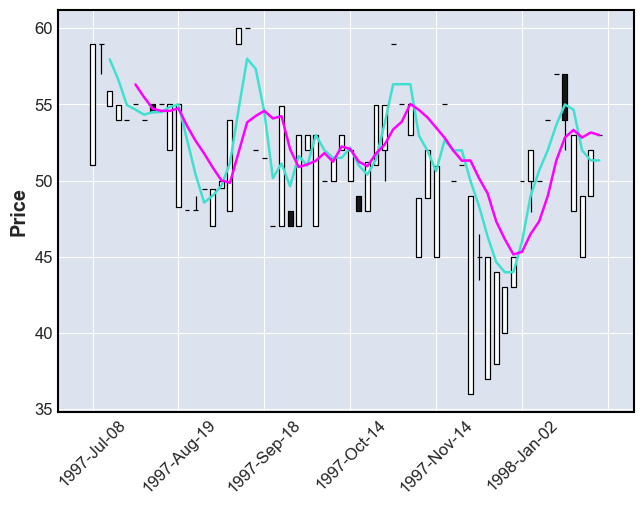

In [31]:
# import mplfinance as mpf
# type : 그래프 형태
# mav : 자동이동평균선을 자동으로 추가
mpf.plot(b3_stock_alp3_n[-60:], type='candle', mav=(3,6))

In [33]:
b3_stock_alp3_n1 = b3_stock_alp3[['date', 'close']]
b3_stock_alp3_n1

,date,close
0,1994-07-04,156.00
1,1994-07-06,160.00
2,1994-07-07,169.98
3,1994-07-12,164.50
4,1994-07-13,163.60
...,...,...
437,1998-02-18,54.00
438,1998-03-03,52.99
439,1998-03-10,49.00
440,1998-03-11,52.00


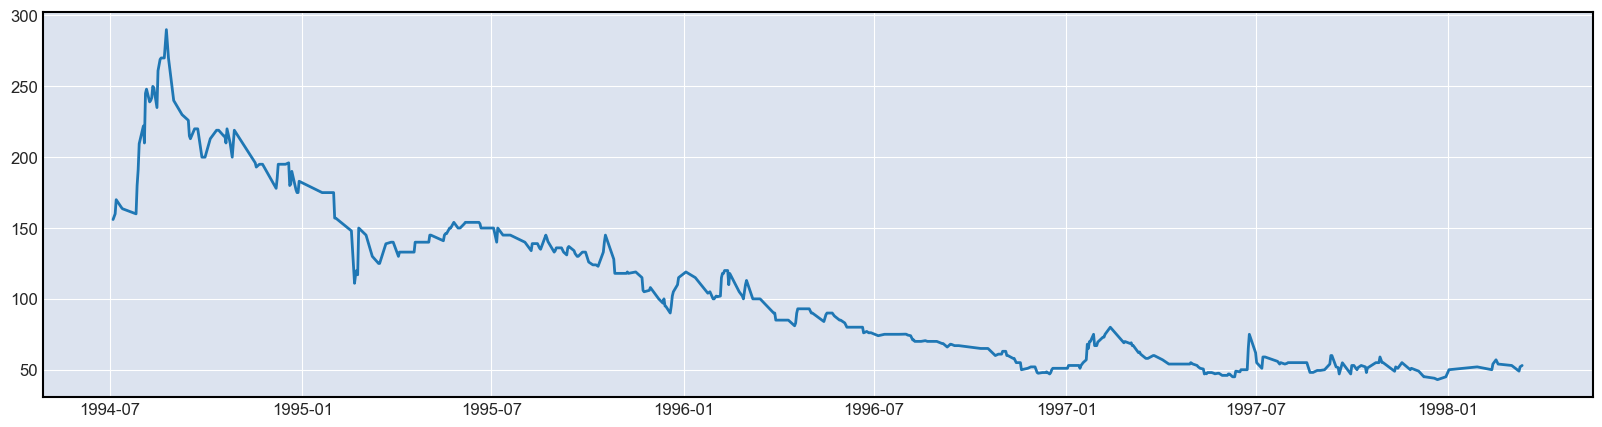

In [36]:
item1 = b3_stock_alp3_n1

item1.columns = ['ds', 'y']
item1['ds'] = item1['ds'].astype('datetime64')
item1['y'] = item1['y'].astype('float')

rcParams['figure.figsize'] = 20, 5
plt.plot(item1.ds, item1.y)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


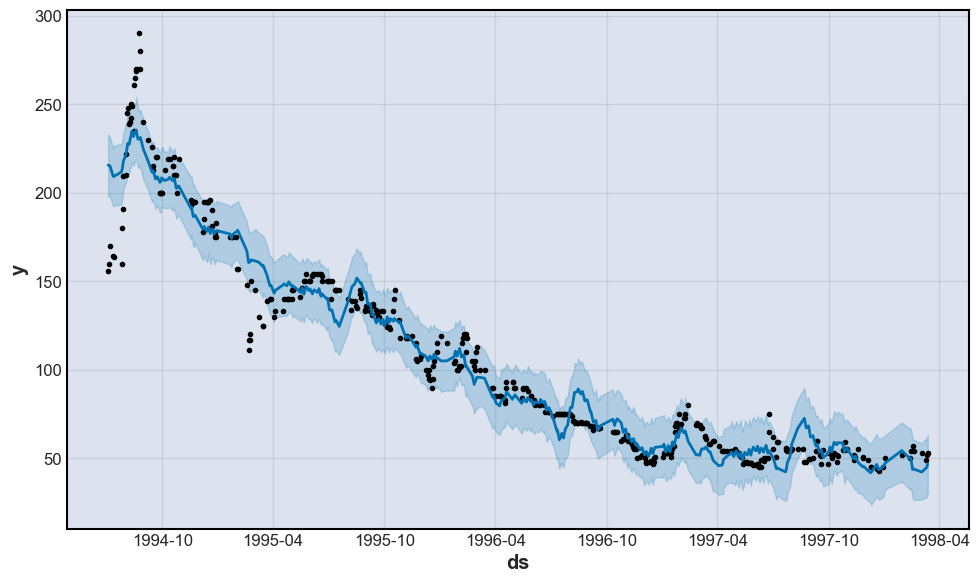

In [37]:
m = Prophet()
m.fit(item1)

forecast1 = m.predict(item1)
figure = m.plot(forecast1)
figure.show()

In [ ]:
# import datetime as dt

In [39]:
from datetime import timedelta
start0 = dt.datetime.strptime('1998-03-14','%Y-%m-%d').date()
end0   = dt.datetime.strptime('2022-12-31','%Y-%m-%d').date()
print(f"start : {start0}, end : {end0}" )
print((end0-start0).days)

start : 1998-03-14, end : 2022-12-31
9058


In [40]:
def daterange(start,end):
    for i in range((end-start).days):
        return start+timedelta(i)  

In [43]:
# 3일만 추가
dates0=[]
for i in range(3):
    dates_one = (start0+timedelta(i)).strftime('%Y-%m-%d')
    print(dates_one)
    dates0 += [ dates_one ]  # 날짜 하나씩 추가
print(dates0[0:10])

1998-03-14
1998-03-15
1998-03-16
['1998-03-14', '1998-03-15', '1998-03-16']


In [45]:
# 9058일 추가
dates0=[]
days = (end0-start0).days  # 9058일
for i in range(days):
    dates_one = (start0+timedelta(i)).strftime('%Y-%m-%d')
    dates0 += [ dates_one ]  # 날짜 하나씩 추가
print(dates0[0:10])

['1998-03-14', '1998-03-15', '1998-03-16', '1998-03-17', '1998-03-18', '1998-03-19', '1998-03-20', '1998-03-21', '1998-03-22', '1998-03-23']


In [46]:
dates0_df = pd.DataFrame(dates0)
dates0_df.columns=['ds']
dates0_df

,ds
0,1998-03-14
1,1998-03-15
2,1998-03-16
3,1998-03-17
4,1998-03-18
...,...
9053,2022-12-26
9054,2022-12-27
9055,2022-12-28
9056,2022-12-29


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


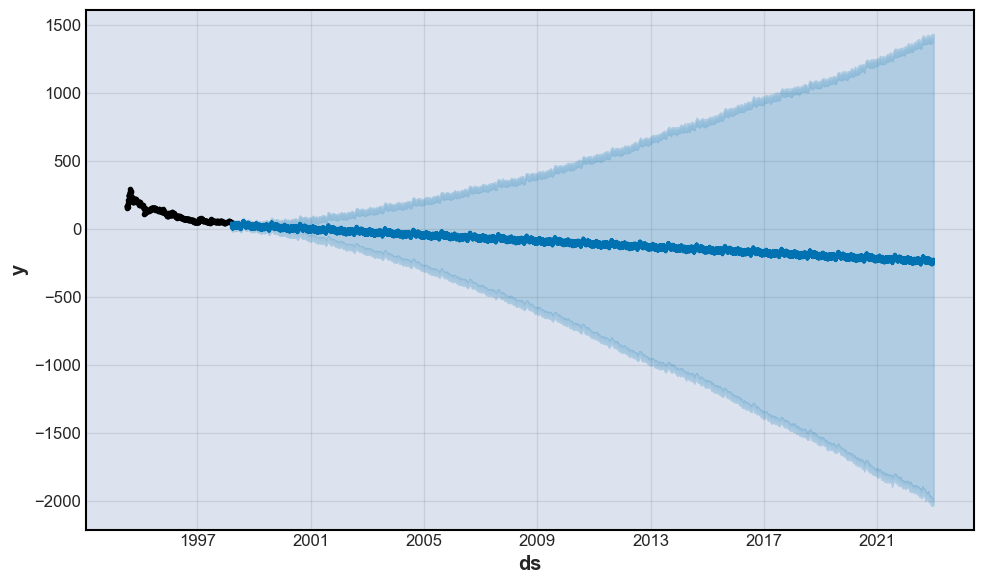

In [47]:
m = Prophet()
m.fit(item1)

forecast3 = m.predict(dates0_df)
figure = m.plot(forecast3)
figure.show()

In [48]:
forecast3[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
9053,2022-12-26,-226.505796,-1994.250171,1428.159945
9054,2022-12-27,-224.944555,-1995.103158,1418.631529
9055,2022-12-28,-224.722590,-1989.526255,1421.065706
9056,2022-12-29,-223.926130,-1998.076745,1420.348726
9057,2022-12-30,-222.673211,-1978.805266,1428.840608


### REF 
 * mplfinace 참조
   * https://github.com/matplotlib/mplfinance
   *https://notebooks.githubusercontent.com/view/ipynb?browser=chrome&color_mode=auto&commit=1f710caa65d872a761ccb5831fb1befd7324881f&device=unknown&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f6d6174706c6f746c69622f6d706c66696e616e63652f316637313063616136356438373261373631636362353833316662316265666437333234383831662f6578616d706c65732f7374796c65732e6970796e62&logged_in=false&nwo=matplotlib%2Fmplfinance&path=examples%2Fstyles.ipynb&platform=android&repository_id=226144726&repository_type=Repository&version=98